In [1]:
import sys

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from torchvision import transforms, datasets
from IPython.display import Image
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

sys.path.append('./scripts/')
import saimple_api as api
import utils as utils

%load_ext autoreload
%autoreload 2


📁 Initialisation et setup du Path

In [2]:
VRS = "v2"
URL = "https://app.saimple.com/api" #mettre son URL 

resources = os.path.join('.', 'data')

Appel de l'API
Dans la version v2, l'authentification est fait par token.

Par exemple en utilisant l'utilisateur user et mot de passe mdp.

Cependant dans la version v1 il n'est pas nécessaire de renseigner une authentification.

In [3]:
# Create a api object with url & version to use
import saimple_api as api

if(VRS == "v2"):
    api = api.SaimpleAPI(URL, VRS, "mgestel", "elongated weary 276")

else:
    api = api.SaimpleAPI(URL, VRS)

api.get_versions()

{'fann': {'build': '2023-08-30 - 11:06',
  'commit': 'a7b49b50f3b18a42e67c87637947af5a59379b0e',
  'tags': '3.8.1',
  'version': '3.8.0'},
 'fann-libAD': {'build': '2023-08-03 - 09:48',
  'commit': '53fb65d1008bf5bd9d2a6391b6f01f2f0d0a4a6a',
  'tags': '4.0.0;4.1.0',
  'version': '4.1.0'},
 'abstari': {'version': '4.1.0', 'additional_info': []}}

In [4]:
# Définir les transformations pour les données
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Redimensionner les images à 224x224
    transforms.ToTensor(),  # Convertir les images en tenseurs PyTorch
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normaliser les images (FashionMNIST est en niveaux de gris)
])

# Télécharger et charger le jeu de données FashionMNIST
dataset = datasets.FashionMNIST(root='./data', 
                                train=True, 
                                transform=transform,
                                download=True)

In [5]:
# Chemin vers le répertoire pour enregistrer les images JPEG
output_dir = './fashion_mnist_images'
os.makedirs(output_dir, exist_ok=True)

# Fonction pour inverser la normalisation et convertir le tenseur en image PIL
def tensor_to_pil_image(tensor):
    tensor = tensor.squeeze()  # Supprimer la dimension du canal
    tensor = (tensor * 255).byte()  # Dé-normaliser et convertir en octet
    return Image.fromarray(tensor.numpy(), mode='L')  # Convertir en image PIL

# Enregistrer les 100 premières images du dataset FashionMNIST en format JPEG
for i in range(100):
    image, label = dataset[i]
    pil_image = tensor_to_pil_image(image)
    pil_image.save(os.path.join(output_dir, f'image_{i}_label_{label}.jpeg'))

print(f'{len(os.listdir(output_dir))} images ont été enregistrées dans le répertoire {output_dir}')

100 images ont été enregistrées dans le répertoire ./fashion_mnist_images


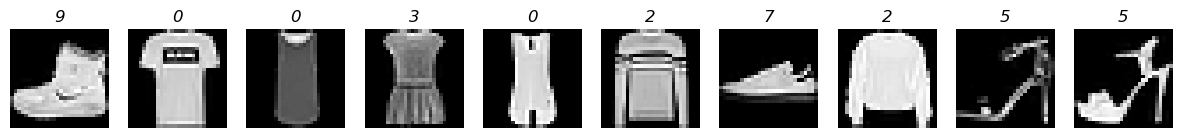

In [6]:
# Créer une figure et des axes pour afficher 10 exemples d'images
fig, axs = plt.subplots(1, 10, figsize=(15, 2))

# Afficher 10 exemples d'images
for i in range(10):
    # Récupérer l'image et l'étiquette
    image, label = dataset[i]
    
    # Convertir l'image de tenseur à numpy array et renormaliser pour l'affichage
    image = image.numpy().squeeze() * 0.5 + 0.5
    
    # Afficher l'image
    axs[i].imshow(image, cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(str(label), fontstyle='italic')

# Afficher la figure
plt.show()

In [64]:
# Sign Language
image_path = os.path.join('fashion_mnist_images/image_8_label_5.jpeg')
# Save image name, needed for evaluations
image_name  = os.path.basename(image_path)

In [65]:
# Post images
# api.post_image(image_path_sign)
sign_input_id = api.post_input(image_path)

In [66]:
model_path = os.path.join('fashionMNIST_MLP_model.onnx')
# Post models & save IDs models
sign_model_id  = api.post_model(model_path)


Successfully uploaded model : fashionMNIST_MLP_model.onnx


## Configuration de l'évaluation
Pour lancer l'évaluation, une configuration est créée conv_eval_sign pour le post.

Elle donne les caractéristiques de l'évaluation, l'image est renseignée en "input" et le modèle en "model", postée au préalable. On assigne un nom à l'évaluation "Eval from API v2" et éventuellement une description. On informe le type d'input "dataType" et son domaine de définition "inputDomain", principalement elles vont de 0 à 255, cependant elles peuvent aussi être de 0 à 1 lorsqu'elles sont normalisées.

"EvaluationEngine" définit le moteur d'évaluation, il existe deux option : difann et fann-c (par défaut). La perturbation des entrées est défini en "noise" avec "intensity" à 0.0001 et il existe plusieurs modes NONE, ADDITIVE, MULTIPLICATIVE, BOKEH et GAUSSIAN.

In [67]:
conf_eval_sign  = {
        "name": "test from NB api v2",
        "dataType": "Image",
        "input": sign_input_id['inputId'],
        "reference": 0,
        "model": sign_model_id['modelId'],
        "description": "Eval from API v2",
        "inputDomain": [
            "0",
            "255"
        ],
        "noise": {
            "intensity": "0.0001",
            "mode": "ADDITIVE"
        },
        "analysisType": "double",
        "channelOrder": "last",
        "normalize":  True,
        "evaluationEngine": "difann"
}

## Lancement de l'évaluation
Le POST déclanche automatiquement l'évaluation, à l'aide de :

POST /api/{version}/evaluations.

In [68]:
print((conf_eval_sign))
evalId = api.post_evaluations(conf_eval_sign)
print("Evaluation id: ", evalId)

{'name': 'test from NB api v2', 'dataType': 'Image', 'input': '110955a2-3d38-11ef-8e09-02420a0000e1', 'reference': 0, 'model': '0f20a934-3d38-11ef-8e09-02420a0000e1', 'description': 'Eval from API v2', 'inputDomain': ['0', '255'], 'noise': {'intensity': '0.0001', 'mode': 'ADDITIVE'}, 'analysisType': 'double', 'channelOrder': 'last', 'normalize': True, 'evaluationEngine': 'difann'}
Evaluation id:  14a5ffee-3d38-11ef-8e09-02420a0000e1


In [69]:
api.get_evaluations(evalId)

{'workspace_path': '/Workspace/mgestel',
 'modelId': '0f20a934-3d38-11ef-8e09-02420a0000e1',
 'inputId': '110955a2-3d38-11ef-8e09-02420a0000e1',
 'status': 'IN_PROGRESS',
 'id': '14a5ffee-3d38-11ef-8e09-02420a0000e1',
 'creationDate': '2024-07-08T16:40:54.566240',
 'evaluationName': 'competent_gates',
 'postProcessing': True,
 'name': 'test from NB api v2',
 'description': 'Eval from API v2',
 'tags': [],
 'dataType': 'Image',
 'inputDomain': ['0', '255'],
 'noise': {'intensity': '0.0001', 'mode': 'ADDITIVE'},
 'analysisType': 'double',
 'channelOrder': 'last',
 'normalize': True,
 'evaluationEngine': 'difann',
 'endDate': '2024-07-08T16:40:56.886943',
 'duration': '00:00:02',
 'message': 'timeout when checking job status,but results were found',
 'inputName': 'image_8_label_5.jpeg',
 'modelName': 'fashionMNIST_MLP_model.onnx'}

In [70]:
# Waiting for the end of the evaluation
while (api.get_eval_status(evalId) == 'IN_PROGRESS'):
    print("\rPlease wait the end of the evaluation.", end='')
    time.sleep(2)
print('\n')

if (api.get_eval_status(evalId) == "DONE"):
    dominance = api.get_dominance(evalId)['classes']
    df_dominance = pd.DataFrame(dominance)
    print(df_dominance)
elif (api.get_evaluations(evalId)['status'] == "FAILED"):
    print("Evaluation failed.")



   id       min       max     status
0   0  0.002227  0.002271  Dominated
1   1  0.000009  0.000009  Dominated
2   2  0.000318  0.000324  Dominated
3   3  0.000009  0.000010  Dominated
4   4  0.000023  0.000023  Dominated
5   5  0.890114  0.890782   Dominant
6   6  0.000006  0.000006  Dominated
7   7  0.003032  0.003075  Dominated
8   8  0.006286  0.006382  Dominated
9   9  0.097279  0.097816  Dominated


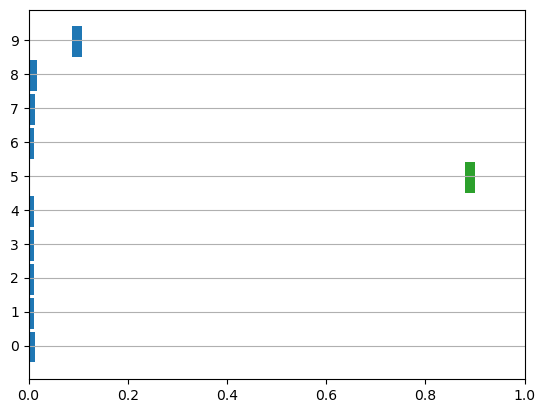

In [71]:
utils.histDominance(df_dominance)

## Relevance
La relevance est obtenue à l'aide de :

GET /api/{version}/evaluations/{evalId}/relevance.

In [72]:
relevance = api.get_relevance(evalId)['data']
df_relevance = pd.DataFrame(relevance[0])
df_relevance

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,[2],[-1],[0],[-2],[0],[-2],[-2],[-1],[9],[3],...,[3],[2],[6],[-2],[-2],[4],[-2],[1],[-1],[-2]
1,[-2],[-1],[0],[1],[5],[7],[9],[31],[10],[4],...,[7],[6],[33],[4],[-2],[0],[2],[-3],[0],[-2]
2,[-4],[-3],[2],[3],[9],[17],[35],[36],[7],[14],...,[1],[2],[14],[35],[6],[0],[3],[3],[-3],[-3]
3,[-3],[-6],[-5],[3],[10],[27],[38],[10],[7],[20],...,[-2],[0],[11],[24],[21],[3],[-2],[-6],[-5],[-1]
4,[-3],[-7],[2],[7],[13],[24],[33],[13],[14],[20],...,[-6],[-3],[10],[21],[15],[4],[-5],[-6],[-7],[-3]
5,[-4],[-8],[3],[8],[13],[33],[31],[9],[1],[-8],...,[-2],[4],[11],[9],[14],[0],[-8],[-12],[-7],[-3]
6,[-3],[-6],[-3],[7],[14],[34],[26],[28],[8],[-2],...,[10],[-4],[11],[10],[13],[-6],[-3],[-11],[-7],[-3]
7,[-6],[-9],[5],[7],[13],[34],[29],[40],[34],[-5],...,[1],[11],[15],[6],[13],[-4],[-4],[-10],[-12],[-8]
8,[-7],[-8],[4],[10],[20],[26],[27],[47],[23],[18],...,[4],[8],[19],[8],[10],[0],[-6],[-8],[-16],[-9]
9,[-8],[-8],[5],[5],[20],[25],[23],[39],[36],[31],...,[16],[6],[5],[15],[9],[7],[-4],[-4],[-18],[-12]


In [73]:
img = np.array(Image.open(os.path.join(image_path)), dtype= float)

utils.showRelevance(df_relevance, img,0.8 )

IndexError: list index out of range